# 第4章　割引クーポンキャンペーンの効果最大化


## 4.3　データ理解

### データの確認

（1）　会員データ（customers.csv）の確認

In [1]:
import pandas as pd
cust_df = pd.read_csv('customers.csv')
cust_df.shape

(5000, 3)

In [2]:
# ファイル上部のレコード
cust_df.head()

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


In [3]:
# データの型
cust_df.dtypes

customer_id     int64
age_cat        object
freq_cat       object
dtype: object

<AxesSubplot:>

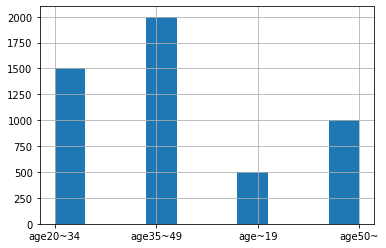

In [4]:
cust_df['age_cat'].hist()

<AxesSubplot:>

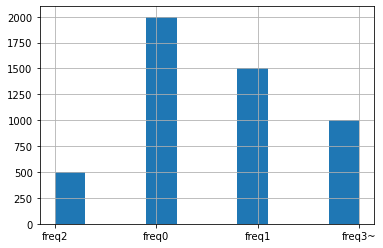

In [5]:
cust_df['freq_cat'].hist()

In [6]:
cust_pivot_df = pd.pivot_table(data=cust_df, values='customer_id', columns='freq_cat', index='age_cat', aggfunc='count')
cust_pivot_df = cust_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
cust_pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age~19,200,150,50,100
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200


<AxesSubplot:xlabel='freq_cat', ylabel='age_cat'>

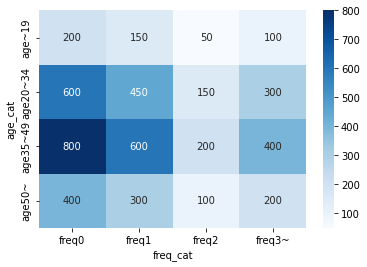

In [7]:
import seaborn as sns
sns.heatmap(cust_pivot_df, annot=True, fmt='d', cmap='Blues')

（2）　来店率データ（visit_probability.csv）の確認

In [8]:
prob_df = pd.read_csv('visit_probability.csv')
prob_df.shape

(16, 6)

In [9]:
prob_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


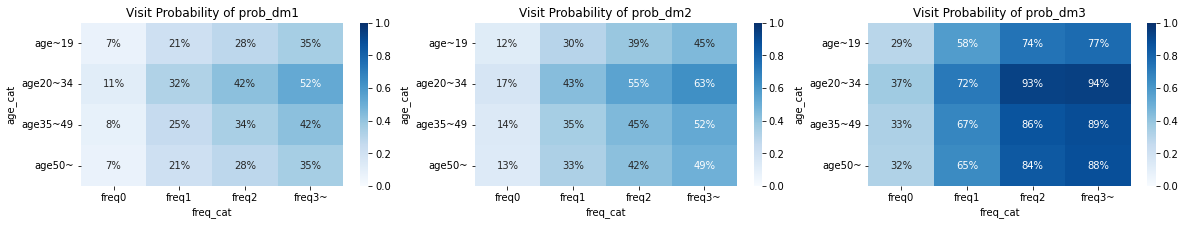

In [10]:
import matplotlib.pyplot as plt
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['prob_dm1', 'prob_dm2', 'prob_dm3']):
    prob_pivot_df = pd.pivot_table(data=prob_df, values=ptn, columns='freq_cat', index='age_cat')
    prob_pivot_df = prob_pivot_df.reindex (['age~19','age20~34', 'age35~49', 'age50~'])
    sns.heatmap(prob_pivot_df, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues', ax=ax[i])
    ax[i].set_title(f'Visit Probability of {ptn}')
plt.show()

## 4.4　数理モデリングと実装

### モデリング1：会員個別送付モデル

In [11]:
# !pip install pulp
import pulp

problem = pulp.LpProblem(name='DiscountCouponProblem1',sense=pulp.LpMaximize)

要件（1）　各会員に対してどのパターンのダイレクトメールを送付するかを決定

In [12]:
# 会員IDのリスト
I = cust_df['customer_id'].to_list()

In [13]:
# ダイレクトメールのパターンのリスト
M = [1, 2, 3]

In [14]:
# （1）各会員に対してどのパターンのダイレクトメールを送付するかを決定
xim = {}
for i in I:
    for m in M:
        xim[i,m] = pulp.LpVariable(name=f'xim({i},{m})',cat='Binary')
# 決定変数の数
len(xim)

15000

要件（2）　各会員に対して送付するダイレクトメールはいずれか1 パターン

In [15]:
#　（2）各会員に対して送付するダイレクトメールはいずれか1パターン
for i in I:
    problem += pulp.lpSum(xim[i,m] for m in M) == 1

要件（3）　クーポン付与による来客増加数を最大化

In [16]:
keys = ['age_cat', 'freq_cat']
cust_prob_df = pd.merge(cust_df, prob_df, on=keys)
cust_prob_df.head()

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,199,age20~34,freq2,7,0.42,0.55,0.93
2,200,age20~34,freq2,7,0.42,0.55,0.93
3,255,age20~34,freq2,7,0.42,0.55,0.93
4,269,age20~34,freq2,7,0.42,0.55,0.93


In [17]:
cust_prob_ver_df = cust_prob_df.rename(columns={'prob_dm1': 1, 'prob_dm2': 2, 'prob_dm3': 3})\
                  .melt(id_vars=['customer_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
cust_prob_ver_df

,customer_id,dm,prob
0,1,1,0.42
1,199,1,0.42
2,200,1,0.42
3,255,1,0.42
4,269,1,0.42
...,...,...,...
14995,4474,3,0.74
14996,4596,3,0.74
14997,4720,3,0.74
14998,4910,3,0.74


In [18]:
Pim = cust_prob_ver_df.set_index(['customer_id','dm'])['prob'].to_dict()

In [19]:
Pim[1,1]

0.42

In [20]:
# （3）クーポン付与による来客増加数を最大化
problem += pulp.lpSum((Pim[i,m] - Pim[i,1]) * xim[i,m] for i in I for m in [2,3])

要件（4）　会員の予算消費期待値の合計は100 万円以下

In [21]:
Cm = {1:0, 2:1000, 3:2000}

In [22]:
# （4）顧客の消費する費用の期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Pim[i,m]* xim[i,m] for i in I for m in [2,3]) <= 1000000

In [23]:
# セグメントのリスト
S = prob_df['segment_id'].to_list()
len(S)

16

In [24]:
# 各セグメントとそのセグメントに属する顧客数を対応させる辞書の作成
Ns = cust_prob_df.groupby('segment_id')['customer_id'].count().to_dict()
print(Ns)

{1: 200, 2: 150, 3: 50, 4: 100, 5: 600, 6: 450, 7: 150, 8: 300, 9: 800, 10: 600, 11: 200, 12: 400, 13: 400, 14: 300, 15: 100, 16: 200}


In [25]:
# 会員をキーとして属するセグメントを返す辞書
Si = cust_prob_df.set_index('customer_id')['segment_id'].to_dict()

要件（5）　各パターンのダイレクトメールをそれぞれのセグメントに属する会員10% 以上に送付

In [26]:
# （5）各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10%以上送付
for s in S:
    for m in M:
        problem += pulp.lpSum(xim[i,m] for i in I if Si[i] == s) >= 0.1 * Ns[s]

In [55]:
# 時間を計測
# モデリング1は、一部の環境ではgapRel（計算の終了判定とする上界と下界のギャップのしきい値）を指定しないと停止しない
# solver = pulp.PULP_CBC_CMD(gapRel=10e-4)

import time
time_start = time.time()
status = problem.solve()
# gapRelを指定した場合はsolve関数にて上でパラメータを指定したsolverを引数にとる
# status = problem.solve(solver)
time_stop = time.time()

In [56]:
print(f'ステータス:{pulp.LpStatus[status]}')
print(f'目的関数値:{pulp.value(problem.objective):.4}')
print(f'計算時間:{(time_stop - time_start):.3}(秒)')

ステータス:Optimal
目的関数値:981.9
計算時間:0.0826(秒)


In [29]:
send_dm_df = pd.DataFrame([[xim[i,m].value() for m in M] for i in I], columns=['send_dm1', 'send_dm2', 'send_dm3'])
send_dm_df.head()

,send_dm1,send_dm2,send_dm3
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


In [30]:
cust_send_df = pd.concat([cust_df[['customer_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
cust_send_df.head()

,customer_id,age_cat,freq_cat,send_dm1,send_dm2,send_dm3
0,1,age20~34,freq2,0.0,1.0,0.0
1,2,age35~49,freq0,0.0,1.0,0.0
2,3,age35~49,freq0,0.0,1.0,0.0
3,4,age~19,freq0,0.0,0.0,1.0
4,5,age35~49,freq0,0.0,1.0,0.0


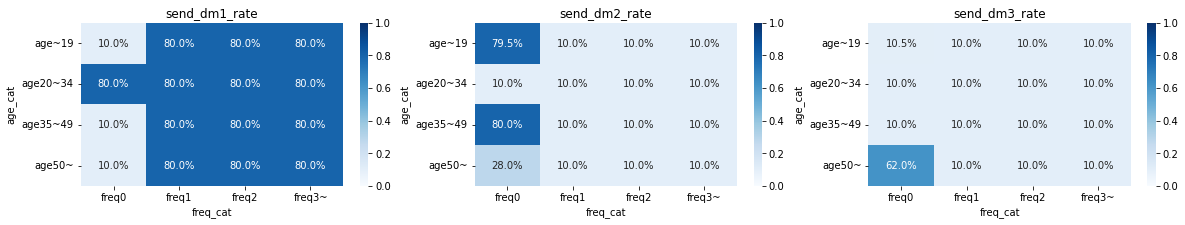

In [31]:
# 各セグメントに対するそれぞれのダイレクトメールの送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
    cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(cust_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}_rate')
plt.show()

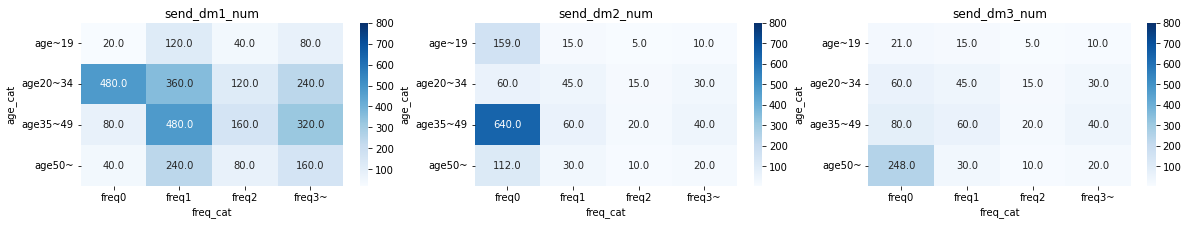

In [32]:
# 各セグメントに対するそれぞれのダイレクトメールの送付数
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat',aggfunc='sum')
    cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(cust_send_pivot_df, annot=True, fmt='.1f', cmap='Blues', vmax=800, ax=ax[i])
    ax[i].set_title(f'{ptn}_num')
plt.show()

### モデリング2：セグメント送付モデル

In [33]:
# 数理モデルのインスタンス作成
problem = pulp.LpProblem(name='DiscountCouponProblem2', sense=pulp.LpMaximize)

要件（1）　各会員に対してどのパターンのダイレクトメールを送付するかを決定

In [34]:
# （1）各会員に対してどのパターンのダイレクトメールを送付するかを決定
xsm = {}
# ［0,1］の変数を宣言
for s in S:
    for m in M:
        xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})',
        lowBound=0, upBound=1, cat='Continuous')
len(xsm)

48

要件（2）　各会員に対して送付するダイレクトメールはいずれか1 パターン

In [35]:
# （2）各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    problem += pulp.lpSum(xsm[s,m] for m in M) == 1

要件（3）　クーポン付与による来客増加数を最大化

In [36]:
prob_ver_df = prob_df.rename(columns={'prob_dm1': 1,'prob_dm2': 2, 'prob_dm3': 3})\
.melt(id_vars=['segment_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
Psm = prob_ver_df.set_index(['segment_id','dm'])['prob'].to_dict()

In [37]:
# （3）クーポン付与による来客増加数を最大化
problem += pulp.lpSum(Ns[s] * (Psm[s,m] - Psm[s,1]) * xsm[s,m] for s in S for m in [2,3])

要件（4）　会員の予算消費期待値の合計は100 万円以下

In [38]:
# （4）会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s,m] * xsm[s,m] for s in S for m in [2,3]) <= 1000000

要件（5）　各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10% 以上送付

In [39]:
# （5）各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10%以上送付
for s in S:
    for m in M:
        problem += xsm[s,m] >= 0.1

In [40]:
time_start = time.time()
status = problem.solve()
time_stop = time.time()
print(f'ステータス:{pulp.LpStatus[status]}')
print(f'目的関数値:{pulp.value(problem.objective):.4}')
print(f'計算時間:{(time_stop - time_start):.3}(秒)')

ステータス:Optimal
目的関数値:326.1
計算時間:0.096(秒)


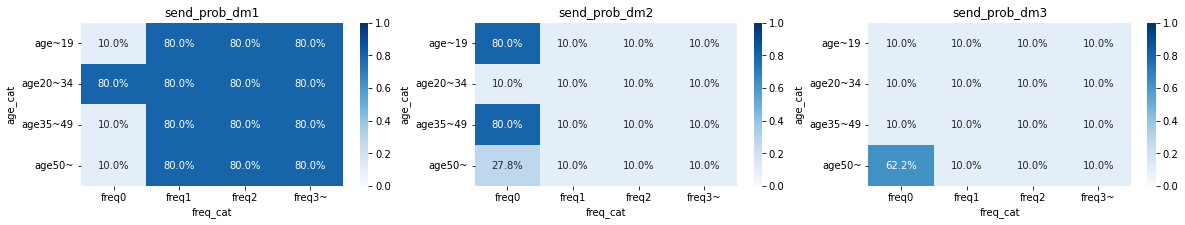

In [41]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M] for s in S], columns=['send_prob_dm1', 'send_prob_dm2','send_prob_dm3'])
seg_send_df = pd.concat([prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
# 各セグメントに対するそれぞれのダイレクトメールの送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

In [42]:
seg_send_df['num_cust'] = seg_send_df['segment_id'].apply(lambda x: Ns[x])
seg_send_df['send_num_dm1'] = seg_send_df['send_prob_dm1']*seg_send_df['num_cust']
seg_send_df['send_num_dm2'] = seg_send_df['send_prob_dm2']*seg_send_df['num_cust']
seg_send_df['send_num_dm3'] = seg_send_df['send_prob_dm3']*seg_send_df['num_cust']
seg_send_df[['segment_id','send_num_dm1','send_num_dm2','send_num_dm3']].head()

,segment_id,send_num_dm1,send_num_dm2,send_num_dm3
0,1,20.0,160.0,20.0
1,2,120.0,15.0,15.0
2,3,40.0,5.0,5.0
3,4,80.0,10.0,10.0
4,5,480.0,60.0,60.0


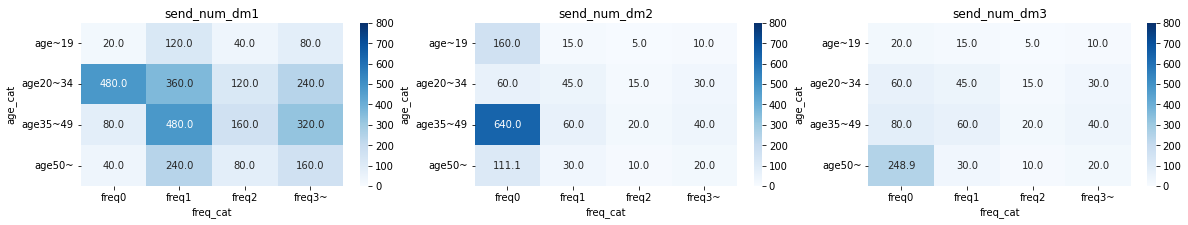

In [43]:
# 各セグメントに対するそれぞれのダイレクトメールの送付数
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_num_dm1','send_num_dm2','send_num_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat', index='age_cat')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1f', cmap='Blues', vmin=0, vmax=800, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

## 4.5 結果の評価

### モデリング3：送付率下限値最大化モデル

In [44]:
# 数理モデルのインスタンス作成
problem = pulp.LpProblem(name='DiscountCouponProblem3', sense=pulp.LpMaximize)

要件（1）各セグメントへのダイレクトメールの送付率の下限値と各会員に対してどのダイレクトメールを送付するかを決定

In [45]:
#　（1）各セグメントへのそれぞれパターンのダイレクトメールの送付率の下限値と各会員に対してどのダイレクトメールを送付するかを決定
# 会員に対してどのダイレクトメールを送付するか
xsm = {}
#　［0,1］の変数を宣言
for s in S:
    for m in M:
        xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})', lowBound=0, upBound=1, cat='Continuous')
# 各セグメントへのそれぞれパターンのダイレクトメールの送付率の下限値
y = pulp.LpVariable(name='y', lowBound=0, upBound=1, cat='Continuous')

要件（3）　各セグメントへのそれぞれのパターンのダイレクトメールの送付率の下限値を最大化

In [46]:
#　（3）各セグメントへのそれぞれパターンのダイレクトメールの送付率の下限値を最大化
problem += y

要件（5）　各パターンのダイレクトメールを設定した送付率の下限値以上送付

In [47]:
#　（5）各パターンのダイレクトメールを設定した送付率の下限値以上送付
for s in S:
    for m in M:
        problem += xsm[s,m] >= y

要件（2）、要件（4）

In [48]:
#　（2）各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    problem += pulp.lpSum(xsm[s,m] for m in M) == 1
#　（4）会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s,m] * xsm[s,m] for s in S for m in [2,3]) <= 1000000

In [49]:
status = problem.solve()
max_lowerbound = pulp.value(problem.objective)
print(f'ステータス: {pulp.LpStatus[status]}, 目的関数値:{max_lowerbound :.3}')

ステータス: Optimal, 目的関数値:0.131


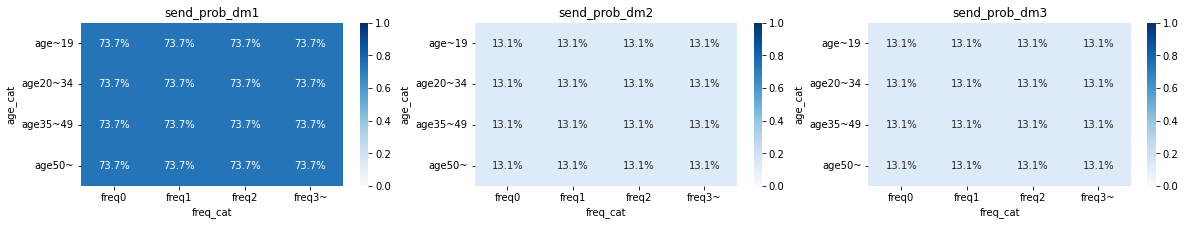

In [50]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M]for s in S], columns=['send_prob_dm1', 'send_prob_dm2','send_prob_dm3'])
seg_send_df = pd.concat([prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat',index='age_cat', aggfunc='mean')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

In [51]:
# 数理モデルのインスタンス作成
problem = pulp.LpProblem(name='DiscountCouponProblem3', sense=pulp.LpMaximize)
#　（1）各セグメントへのそれぞれパターンのダイレクトメールの送付率の下限値と各会員に対してどのダイレクトメールを送付するかを決定
# 会員に対してどのダイレクトメールを送付するか
x = {}
#　［0,1］の変数を宣言
for s in S:
    for m in M:
        xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})',lowBound=0, upBound=1, cat='Continuous')
#　（2）各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    problem += pulp.lpSum(xsm[s,m] for m in M) == 1
#　（3）クーポン付与による来客増加数を最大化
problem += pulp.lpSum(Ns[s] * (Psm[s,m] - Psm[s,1]) * xsm[s,m] for s in S for m in [2,3])
#　（4）会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s,m] * xsm[s,m] for s in S for m in [2,3]) <= 1000000
#　（5）各パターンのダイレクトメールを設定した送付率の下限値以上送付
for s in S:
    for m in M:
        problem += xsm[s,m] >= max_lowerbound
status = problem.solve()
print(f'ステータス: {pulp.LpStatus[status]}, 目的関数値:{pulp.value(problem.objective):.4}')

ステータス: Optimal, 目的関数値:300.6


### 投資対効果の評価

In [52]:
cost_list = []
cpa_list = []
inc_action_list = []

In [53]:
print('ステータス, キャンペーン費用, 来客増加数, CPA')
for cost in range(761850, 3000000, 100000):
    # 数理モデルのインスタンス作成
    problem = pulp.LpProblem(name='DiscountCouponProblem2', sense=pulp.LpMaximize)
    #　（1）各セグメントへのそれぞれパターンのダイレクトメールの送付率の下限値と各会員に対してどのダイレクトメールを送付するかを決定
    # 会員に対してどのダイレクトメールを送付するか
    xsm = {}
    # [0,1]の変数を宣言
    for s in S:
        for m in M:
            xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})', lowBound=0, upBound=1, cat='Continuous')
    #　（2）各会員に対して送付するダイレクトメールはいずれか1パターン
    for s in S:
        problem += pulp.lpSum(xsm[s,m] for m in M) == 1
    #　（3）割引券付与による来客増加数を最大化
    problem += pulp.lpSum(Ns[s] * (Psm[s,m] - Psm[s,1]) * xsm[s,m] for s in S for m in [2,3])
    #　（4）会員の予算消費期待値の合計はcost円以下
    problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s,m] * xsm[s,m] for s in S for m in [2,3]) <= cost
    #　（5）各パターンのダイレクトメールを設定した送付率の下限値以上送付
    for s in S:
        for m in M:
            problem += xsm[s,m] >= 0.1
    status = problem.solve()
    cpa = cost/pulp.value(problem.objective)
    inc_action = pulp.value(problem.objective)
    cost_list.append(cost)
    cpa_list.append(cpa)
    inc_action_list.append(inc_action)
    print(f'{pulp.LpStatus[status]}, {cost}, {inc_action :.4}, {cpa :.5}')

ステータス, キャンペーン費用, 来客増加数, CPA
Optimal, 761850, 229.0, 3326.9
Optimal, 861850, 273.1, 3156.3
Optimal, 961850, 311.9, 3084.0
Optimal, 1061850, 349.1, 3042.0
Optimal, 1161850, 385.8, 3011.8
Optimal, 1261850, 422.3, 2988.0
Optimal, 1361850, 458.8, 2968.0
Optimal, 1461850, 495.2, 2951.8
Optimal, 1561850, 530.5, 2944.2
Optimal, 1661850, 565.6, 2938.4
Optimal, 1761850, 600.7, 2933.2
Optimal, 1861850, 634.2, 2935.9
Optimal, 1961850, 667.3, 2940.2
Optimal, 2061850, 700.2, 2944.5
Optimal, 2161850, 732.5, 2951.4
Optimal, 2261850, 764.1, 2960.1
Optimal, 2361850, 795.5, 2969.2
Optimal, 2461850, 826.8, 2977.5
Optimal, 2561850, 858.1, 2985.3
Optimal, 2661850, 889.5, 2992.6
Optimal, 2761850, 920.8, 2999.3
Optimal, 2861850, 951.7, 3007.1
Optimal, 2961850, 981.9, 3016.4


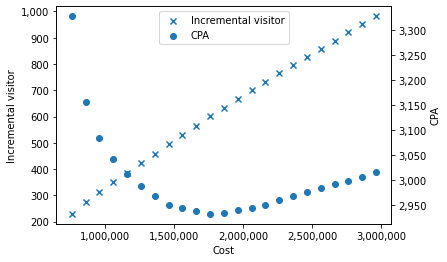

In [54]:
import matplotlib.ticker as ticker
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(cost_list, inc_action_list, marker='x', label='Incremental visitor')
ax2.scatter(cost_list, cpa_list, label='CPA')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax1.set_xlabel('Cost')
ax1.set_ylabel('Incremental visitor')
ax2.set_ylabel('CPA')
reg1, label1 = ax1.get_legend_handles_labels()
reg2, label2 = ax2.get_legend_handles_labels()
ax2.legend(reg1 + reg2, label1 + label2, loc='upper center')
plt.show()